---

Universidade Federal do Rio Grande do Norte

Centro de Tecnologia

Departamento de Engenharia de Computação e Automação

ELE0606 - Tópicos especiais em inteligência artificial

Student: Levy Gabriel da Silva Galvão

Título: Clustering with K-means

---

# Libraries import

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

sns.set_theme();
!pip install kneed &> /dev/null

# Machine Learning

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from kneed import KneeLocator

# Objective

The objective of this work is to parse the results of clustering using the K-means model from Scikit-learn in three different dataset: Iris, Wine, and Synthetic Control Chart Time Series. The description of these datasets has been done over and over again before, so no introduction is needed. 

# Datasets

There will be used three different classification datasets, but biased for clustering, since omitting the labels, the features alone simple model a clustering problem.

Also PCA is used as a first analysis to allow to plot the datasets in 2D given a slightly idea of how the centroids of each cluster will be distributed


The function `pca_plot` helps to plot each dataset in 2D using PCA.

In [2]:
def pca_plot(df, title):
  X = np.array(df.drop(columns=['target'])) # original feature matrix
  y = np.array(df['target'])
  target_names = np.unique(y)
  pca = PCA(n_components=2)
  X2D = pca.fit(X).transform(X) # feature matrix after pca

  print('Explained variance ratio: %s' % str(pca.explained_variance_ratio_))

  plt.figure()
  for target_name in target_names:
    plt.scatter(
        x=X2D[y==target_name, 0], y=X2D[y==target_name, 1], c=[np.random.rand(3,)], label=target_name
    )
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.title(title)
  plt.show()

## Iris

For the iris dataset:

In [3]:
filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df_iris = pd.read_csv(filename, header=None)
df_iris.columns = ['sepal_lentgh', 'sepal_width', 'petal_length', 'petal_width', 'target']
X_iris = MinMaxScaler().fit_transform(np.array(df_iris.drop(columns=['target'])))
df_iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_lentgh  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   target        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Below is shown the target distribution of the Iris dataset:

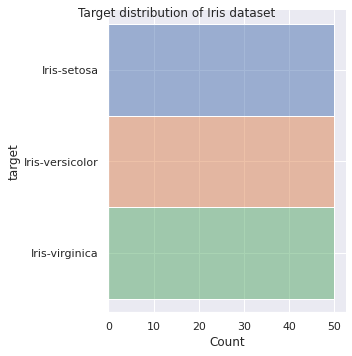

In [4]:
sns.displot(df_iris, y='target', hue='target', legend=False).fig.suptitle('Target distribution of Iris dataset');

Explained variance ratio: [0.92461621 0.05301557]


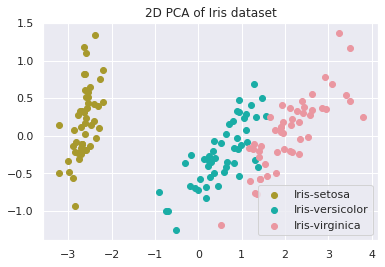

In [5]:
pca_plot(df_iris, '2D PCA of Iris dataset')

Visualizing the Iris results, the PCA kept each label clearly separated from each other and still represeting 97% of the original dataset variance.

Next K-means will be applied to the dataset - using only the features and discarding the targets - and the number of cluster will vary according to the elbow method so this ideal number of cluster can be defined. 

It is important to notice that, once there is the ideal number of classes defined by the targets, it is expected to obtain a good number of clusters close to the number of targets.

So running the K-means for a variable number of clusters, the inertia parameter can be observed. Once the inertia stagnates it means there is no further gain using more clusters.

In [6]:
range_ = np.arange(1,15+1,1)
inertia = []

for k in range_:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X_iris)
  inertia.append(kmeans.inertia_)

cluster_df = pd.DataFrame({'cluster':range_, 'inertia':inertia})
cluster_df.head()

,cluster,inertia
0,1,41.138172
1,2,12.143688
2,3,6.998114
3,4,5.532831
4,5,4.580007


Ploting the inertia as a function of the cluster size:

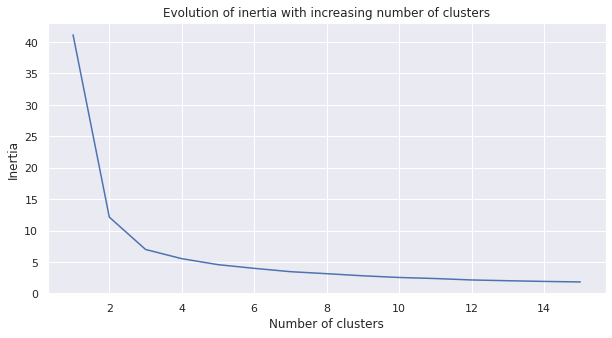

In [7]:
plt.figure(figsize=(10,5))
plt.plot(cluster_df['cluster'], cluster_df['inertia'])
plt.title('Evolution of inertia with increasing number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

The libary `kneed` will be used to detect the knee of which represents the number of clusters that the inertia stagnates:

In [8]:
kl = KneeLocator(cluster_df['cluster'], cluster_df['inertia'], curve="convex", direction="decreasing" )
kl.elbow

3

Once the Iris dataset has 3 different classes, as seen in the graph above, the inertia tends to stagnate after the number of clusters defined to 3. Also the `kneed` library identified the knee as if. So for a final analysis, the Iris dataset will be trained using only 3 clusters.

So fitting the model and making predictions, it obtains:

In [9]:
kmeans = KMeans(kl.elbow)
kmeans = kmeans.fit(X_iris)
pred = kmeans.predict(X_iris)

values, counts = np.unique(pred, return_counts=True)
values = np.char.mod('cluster %d', values)
print('Predictions counting: ' + str(dict(zip(values,counts))))

values, counts = np.unique(np.array(df_iris.filter(['target'])), return_counts=True)
values = np.char.mod('cluster %s', values)
print('True labels counting: ' + str(dict(zip(values,counts))))

Predictions counting: {'cluster 0': 61, 'cluster 1': 50, 'cluster 2': 39}
True labels counting: {'cluster Iris-setosa': 50, 'cluster Iris-versicolor': 50, 'cluster Iris-virginica': 50}


It is important to make it clear that, once the clusters and the targets for the test set not exaclty have any numerical or cathegorical relation, it means that they cannot be related to achieve a score. But parsing the counting of each cluster occurrence and the counting of true labels shows a slightly difference in the cluster 0 and 2 that king of mixes together.

But the clusters can be plotted along to its centroids using PCA to a 2D reduction:

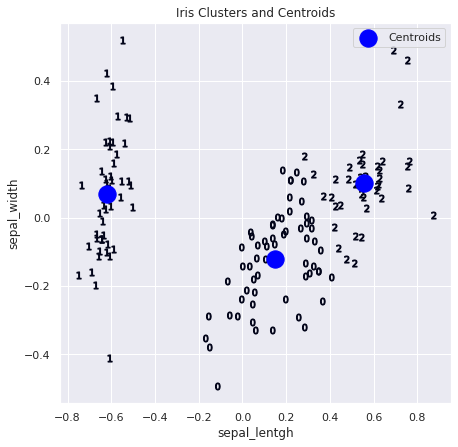

In [10]:
pca = PCA(n_components=2)
X2D = pca.fit(X_iris).transform(X_iris)
CENT = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,7))
for i in range(len(kmeans.labels_)): 
  plt.scatter(X2D[i,0], X2D[i,1], s=50, c=kmeans.labels_[i], marker='$'+str(kmeans.labels_[i])+'$')
plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
plt.title('Iris Clusters and Centroids')
plt.xlabel(df_iris.columns[0])
plt.ylabel(df_iris.columns[1])
plt.legend();

The plot shows that the cluster number 1 is fully separated from the others two, and those despite being clearly indetifiable as two separate entities, they have some data points that are mistaken allocated, but in general it is a good result for the Iris dataset.

The same analysis will be taken in the others datasets, but the focus will be in the results since the coding steps are the same as for the Iris dataset.

## Wine

For the wine dataset:

In [11]:
filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df_wine = pd.read_csv(filename, header=None)
df_wine.columns = ['target', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 
              'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 
              'color_intensity', 'hue', 'OD280/OD315_of_diluted_wines', 'proline']
df_wine['target'] = df_wine['target'].astype(str)
X_wine = MinMaxScaler().fit_transform(np.array(df_wine.drop(columns=['target'])))
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   target                        178 non-null    object 
 1   alcohol                       178 non-null    float64
 2   malic_acid                    178 non-null    float64
 3   ash                           178 non-null    float64
 4   alcalinity_of_ash             178 non-null    float64
 5   magnesium                     178 non-null    int64  
 6   total_phenols                 178 non-null    float64
 7   flavanoids                    178 non-null    float64
 8   nonflavanoid_phenols          178 non-null    float64
 9   proanthocyanins               178 non-null    float64
 10  color_intensity               178 non-null    float64
 11  hue                           178 non-null    float64
 12  OD280/OD315_of_diluted_wines  178 non-null    float64
 13  proli

And bellow is the target distribution histogram plot to confirm the number of instances of each class:

Text(0.5, 0.98, 'Target distribution of Wine dataset')

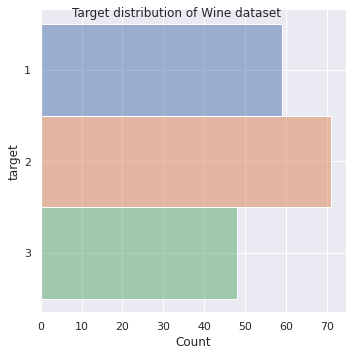

In [12]:
sns.displot(df_wine, y='target', hue='target', legend=False).fig.suptitle('Target distribution of Wine dataset')

Explained variance ratio: [0.99809123 0.00173592]


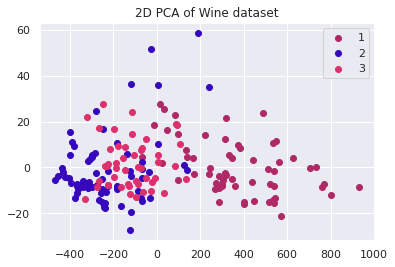

In [13]:
pca_plot(df_wine, '2D PCA of Wine dataset')

Different from the Iris dataset, the wine dataset does not present a clear separation between labels, specially in the middle point of intersection. The last resource is to rely on the training of the ML model to use the advanta of an explained variance of almost 100% to allow a clear separation between labels.

Again the elbow method is used to analyze the best possible number of clusters:

In [14]:
range_ = np.arange(1,15+1,1)
inertia = []

for k in range_:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X_wine)
  inertia.append(kmeans.inertia_)

cluster_df = pd.DataFrame({'cluster':range_, 'inertia':inertia})
cluster_df.head()

,cluster,inertia
0,1,95.599538
1,2,64.537667
2,3,48.954036
3,4,44.769331
4,5,42.134269


Ploting the inertia as a function of the cluster size:

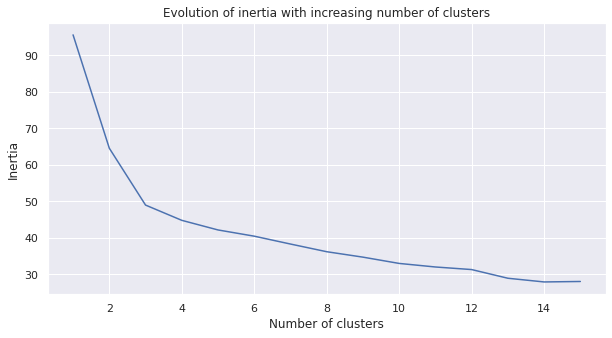

In [15]:
plt.figure(figsize=(10,5))
plt.plot(cluster_df['cluster'], cluster_df['inertia'])
plt.title('Evolution of inertia with increasing number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

The libary `kneed` will be used to detect the knee of which represents the number of clusters that the inertia stagnates:

In [16]:
kl = KneeLocator(cluster_df['cluster'], cluster_df['inertia'], curve="convex", direction="decreasing" )
kl.elbow

3

Again, the number of classes in the Wine dataset is 3, and the elboy method with the help of the `kneed` library identified as such.

So fitting the model and making predictions for 3 clusters, it obtains:

In [17]:
kmeans = KMeans(kl.elbow)
kmeans = kmeans.fit(X_wine)
pred = kmeans.predict(X_wine)

values, counts = np.unique(pred, return_counts=True)
values = np.char.mod('cluster %d', values)
print('Predictions counting: ' + str(dict(zip(values,counts))))

values, counts = np.unique(np.array(df_wine.filter(['target'])), return_counts=True)
values = np.char.mod('cluster %s', values)
print('True labels counting: ' + str(dict(zip(values,counts))))

Predictions counting: {'cluster 0': 63, 'cluster 1': 61, 'cluster 2': 54}
True labels counting: {'cluster 1': 59, 'cluster 2': 71, 'cluster 3': 48}


In this case both the prediction and true labels counting ressembles better than the Iris dataset. The scatter plot below of the clusters helps to visualize better the results in case if there is any crossing of the data points.

Again PCA is used to reduce the dataset to 2D points to a easy display of the clusters.

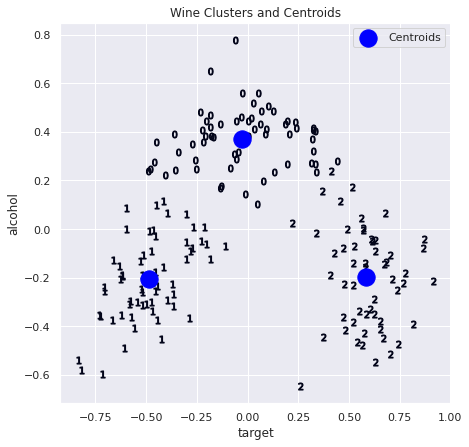

In [18]:
pca = PCA(n_components=2)
X2D = pca.fit(X_wine).transform(X_wine)
CENT = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,7))
for i in range(len(kmeans.labels_)): 
  plt.scatter(X2D[i,0], X2D[i,1], s=50, c=kmeans.labels_[i], marker='$'+str(kmeans.labels_[i])+'$')
plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
plt.title('Wine Clusters and Centroids')
plt.xlabel(df_wine.columns[0])
plt.ylabel(df_wine.columns[1])
plt.legend();

In this case the data points are more separated in its own cluster with a low number of crossing between clusters.

## Synthetic Control Chart Time Series

For the synthetic control chart time series:

In [19]:
filename = 'https://archive.ics.uci.edu/ml/machine-learning-databases/synthetic_control-mld/synthetic_control.data'
df_ctrl = pd.read_csv(filename, header=None, delim_whitespace=True)
repeat_num = 100
df_ctrl['target'] = pd.Series(np.concatenate((
                              np.repeat('normal',repeat_num),
                              np.repeat('cyclic',repeat_num),
                              np.repeat('increasing_trend',repeat_num),
                              np.repeat('decreasing_trend',repeat_num),
                              np.repeat('upward_shift',repeat_num),
                              np.repeat('downward_shift',repeat_num),
                              ), axis=0))
X_ctrl = MinMaxScaler().fit_transform(np.array(df_ctrl.drop(columns=['target'])))
df_ctrl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       600 non-null    float64
 1   1       600 non-null    float64
 2   2       600 non-null    float64
 3   3       600 non-null    float64
 4   4       600 non-null    float64
 5   5       600 non-null    float64
 6   6       600 non-null    float64
 7   7       600 non-null    float64
 8   8       600 non-null    float64
 9   9       600 non-null    float64
 10  10      600 non-null    float64
 11  11      600 non-null    float64
 12  12      600 non-null    float64
 13  13      600 non-null    float64
 14  14      600 non-null    float64
 15  15      600 non-null    float64
 16  16      600 non-null    float64
 17  17      600 non-null    float64
 18  18      600 non-null    float64
 19  19      600 non-null    float64
 20  20      600 non-null    float64
 21  21      600 non-null    float64
 22  22

Its target distribution is as below:

Text(0.5, 0.98, 'Target distribution of Control dataset')

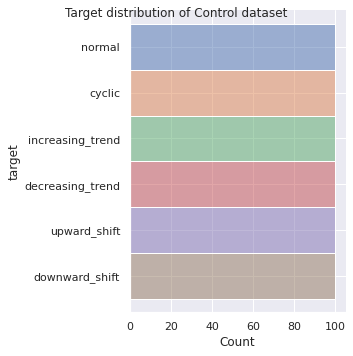

In [20]:
sns.displot(df_ctrl, y='target', hue='target', legend=False).fig.suptitle('Target distribution of Control dataset')

Explained variance ratio: [0.73293525 0.03842952]


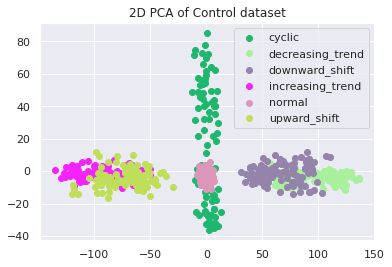

In [21]:
pca_plot(df_ctrl, '2D PCA of Control dataset')

The control dataset, despite multiples labels and low explained variance of 77%, visually it shows distinct patterns of separation for each different label. The labels with "upward" and "increasing" share similarities, so "decreasing" and "downward", thus grouping near each other, but with few differences and "decreasing" and "increasing" mirroring each other, so "downward" and "upward".

Again the elbow method is used to analyze the best possible number of clusters:

In [22]:
range_ = np.arange(1,15+1,1)
inertia = []

for k in range_:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X_ctrl)
  inertia.append(kmeans.inertia_)

cluster_df = pd.DataFrame({'cluster':range_, 'inertia':inertia})
cluster_df.head()

,cluster,inertia
0,1,1666.418117
1,2,983.287050
2,3,724.269522
3,4,645.518707
4,5,581.519888


Ploting the inertia as a function of the cluster size:

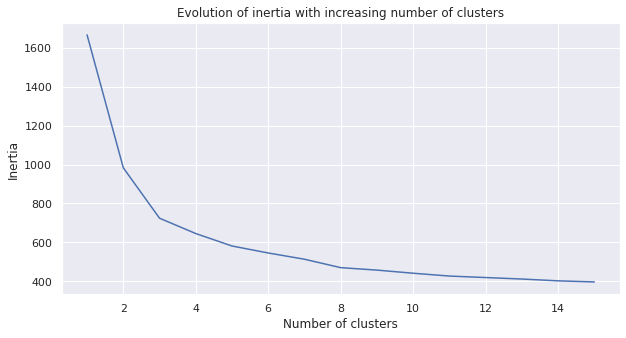

In [23]:
plt.figure(figsize=(10,5))
plt.plot(cluster_df['cluster'], cluster_df['inertia'])
plt.title('Evolution of inertia with increasing number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

The libary `kneed` will be used to detect the knee of which represents the number of clusters that the inertia stagnates:

In [24]:
kl = KneeLocator(cluster_df['cluster'], cluster_df['inertia'], curve="convex", direction="decreasing" )
kl.elbow

3

The best number of clusters for this dataset represents a funny curiosity. Despite it having 6 classes, therefore 6 clusters would be the best choice. But returning to the PCA plot for this dataset, it shows that the classes form clusters in groups of two, then resulting in three clusters that may get confused in the K-means algorithm.

In this case both the numbers of clusters will be tested, first 3 and then 6.

In this case PCA must be used to address the data points and the cluster centroids to a 2D plane.

In [25]:
kmeans = KMeans(kl.elbow)
kmeans = kmeans.fit(X_ctrl)
pred = kmeans.predict(X_ctrl)

values, counts = np.unique(pred, return_counts=True)
values = np.char.mod('cluster %d', values)
print('Predictions counting: ' + str(dict(zip(values,counts))))

values, counts = np.unique(np.array(df_ctrl.filter(['target'])), return_counts=True)
values = np.char.mod('cluster %s', values)
print('True labels counting: ' + str(dict(zip(values,counts))))

Predictions counting: {'cluster 0': 198, 'cluster 1': 194, 'cluster 2': 208}
True labels counting: {'cluster cyclic': 100, 'cluster decreasing_trend': 100, 'cluster downward_shift': 100, 'cluster increasing_trend': 100, 'cluster normal': 100, 'cluster upward_shift': 100}


In this case both the prediction and true labels counting ressembles better than the Iris dataset. The scatter plot below of the clusters helps to visualize better the results in case if there is any crossing of the data points.

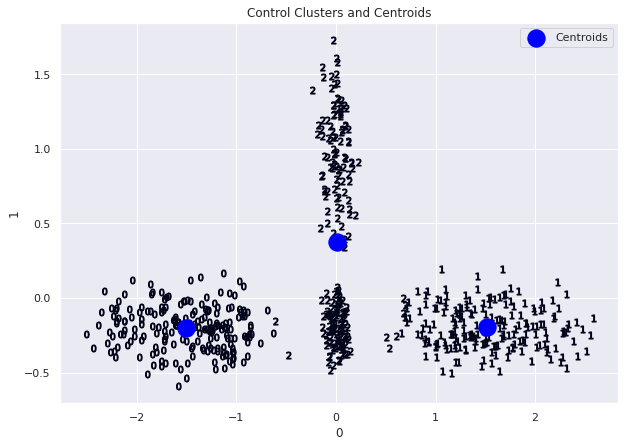

In [26]:
pca = PCA(n_components=2)
X2D = pca.fit(X_ctrl).transform(X_ctrl)
CENT = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,7))
for i in range(len(kmeans.labels_)): 
  plt.scatter(X2D[i,0], X2D[i,1], s=50, c=kmeans.labels_[i], marker='$'+str(kmeans.labels_[i])+'$')
plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
plt.title('Control Clusters and Centroids')
plt.xlabel(df_ctrl.columns[0])
plt.ylabel(df_ctrl.columns[1])
plt.legend();

Using only three clusters shows confusing results, since a clear group of data points in the center that are distinct are addressed to the closest cluster. Again, trying the same analysis but with the actual number of clusters of 6.

In [27]:
kmeans = KMeans(6)
kmeans = kmeans.fit(X_ctrl)
pred = kmeans.predict(X_ctrl)

values, counts = np.unique(pred, return_counts=True)
values = np.char.mod('cluster %d', values)
print('Predictions counting: ' + str(dict(zip(values,counts))))

values, counts = np.unique(np.array(df_ctrl.filter(['target'])), return_counts=True)
values = np.char.mod('cluster %s', values)
print('True labels counting: ' + str(dict(zip(values,counts))))

Predictions counting: {'cluster 0': 105, 'cluster 1': 196, 'cluster 2': 49, 'cluster 3': 82, 'cluster 4': 51, 'cluster 5': 117}
True labels counting: {'cluster cyclic': 100, 'cluster decreasing_trend': 100, 'cluster downward_shift': 100, 'cluster increasing_trend': 100, 'cluster normal': 100, 'cluster upward_shift': 100}


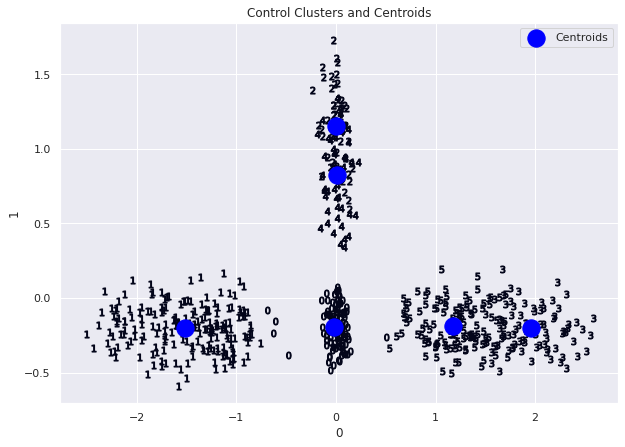

In [28]:
pca = PCA(n_components=2)
X2D = pca.fit(X_ctrl).transform(X_ctrl)
CENT = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,7))
for i in range(len(kmeans.labels_)): 
  plt.scatter(X2D[i,0], X2D[i,1], s=50, c=kmeans.labels_[i], marker='$'+str(kmeans.labels_[i])+'$')
plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
plt.title('Control Clusters and Centroids')
plt.xlabel(df_ctrl.columns[0])
plt.ylabel(df_ctrl.columns[1])
plt.legend();

In this case better results are shown, since the clusters are better distributed.

Visually there are only 4 clusters since some classes are closer related, but the K-means algorithm shows better results than using only 3 clusters. Clearly the use of only 4 clusters will represent the reality of the plot as shown below.

In [29]:
kmeans = KMeans(4)
kmeans = kmeans.fit(X_ctrl)
pred = kmeans.predict(X_ctrl)

values, counts = np.unique(pred, return_counts=True)
values = np.char.mod('cluster %d', values)
print('Predictions counting: ' + str(dict(zip(values,counts))))

values, counts = np.unique(np.array(df_ctrl.filter(['target'])), return_counts=True)
values = np.char.mod('cluster %s', values)
print('True labels counting: ' + str(dict(zip(values,counts))))

Predictions counting: {'cluster 0': 196, 'cluster 1': 187, 'cluster 2': 75, 'cluster 3': 142}
True labels counting: {'cluster cyclic': 100, 'cluster decreasing_trend': 100, 'cluster downward_shift': 100, 'cluster increasing_trend': 100, 'cluster normal': 100, 'cluster upward_shift': 100}


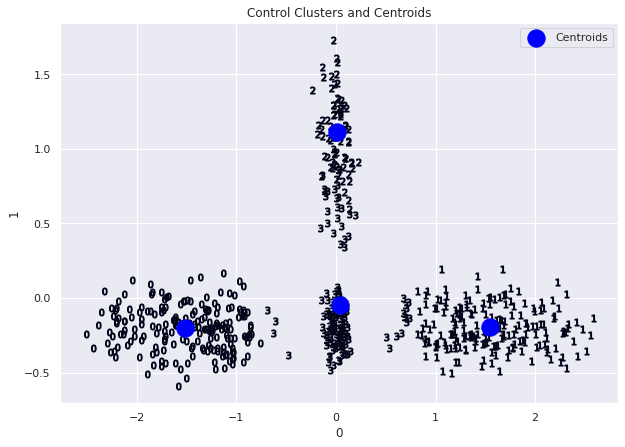

In [30]:
pca = PCA(n_components=2)
X2D = pca.fit(X_ctrl).transform(X_ctrl)
CENT = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10,7))
for i in range(len(kmeans.labels_)): 
  plt.scatter(X2D[i,0], X2D[i,1], s=50, c=kmeans.labels_[i], marker='$'+str(kmeans.labels_[i])+'$')
plt.scatter(CENT[:, 0], CENT[:, 1], s=300, c='blue', label='Centroids')
plt.title('Control Clusters and Centroids')
plt.xlabel(df_ctrl.columns[0])
plt.ylabel(df_ctrl.columns[1])
plt.legend();